## Import Libraries 

In [3]:
# Import Libraries
import numpy as np
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

#Import SciKit Learn and Math
import scipy
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

#estimators
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn import linear_model

#model metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split

## Import Dataset

In [4]:
#Import Data
credit = pd.read_csv('credit.csv', skiprows = 1)

In [5]:
#Import Pay Status Table - definitions of pay status (applies to all '_STATUS' columns)
table = pd.read_csv('Pay Legend Table.csv')
table.head(6)

,PAY STATUS,Monthly Credit Status
0,-2,No consumption
1,-1,Paid in full
2,0,Revolving Credit
3,1,Pay delay 1 month
4,2,Pay delay 2 months
5,9,Pay delay 9 months


In [6]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  int64 
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  object
 3   EDUCATION                   30000 non-null  object
 4   MARRIAGE                    30000 non-null  int64 
 5   AGE                         30000 non-null  int64 
 6   SEPT_STATUS                 30000 non-null  int64 
 7   AUG_STATUS                  30000 non-null  int64 
 8   JULY_STATUS                 30000 non-null  int64 
 9   JUNE_STATUS                 30000 non-null  int64 
 10  MAY_STATUS                  30000 non-null  int64 
 11  APRIL_STATUS                30000 non-null  int64 
 12  SEPT_BILL                   30000 non-null  int64 
 13  AUG_BILL                    30000 non-null  in

In [7]:
#Rename Column 'default payment next month'
credit['default'] = credit ['default payment next month']
#drop unneeded columns
credit=credit.drop(['ID', 'default payment next month'], axis=1)
#drop duplicates
credit = credit.drop_duplicates()
#check for missing values
print(credit.isnull().sum())

LIMIT_BAL        0
SEX              0
EDUCATION        0
MARRIAGE         0
AGE              0
SEPT_STATUS      0
AUG_STATUS       0
JULY_STATUS      0
JUNE_STATUS      0
MAY_STATUS       0
APRIL_STATUS     0
SEPT_BILL        0
AUG_BILL         0
JULY_BILL        0
JUNE_BILL        0
MAY_BILL         0
APRIL_BILL       0
SEPT_PAYMENT     0
AUG_PAYMENT      0
JULY_PAYMENT     0
JUNE_PAYMENT     0
MAY_PAYMENT      0
APRIL_PAYMENT    0
default          0
dtype: int64


In [8]:
#Confirm that 'SEX' has only 2 unique entries and can be Label Encoded
credit['SEX'].describe()

count      29965
unique         2
top       female
freq       18091
Name: SEX, dtype: object

In [9]:
#Confirm that 'default' has only 2 unique entries and can be Label Encoded
credit['default'].describe()

count           29965
unique              2
top       not default
freq            23335
Name: default, dtype: object

In [10]:
#Confirm that "Education" has 4 unique entries and requires One Hot Encoding
credit['EDUCATION'].describe()

count          29965
unique             4
top       university
freq           14019
Name: EDUCATION, dtype: object

In [11]:
#Label Encode 'SEX' to binary 0 and 1 for female and male
le = LabelEncoder()
le.fit(credit['SEX'])
credit['SEX'] = le.transform(credit['SEX'])

In [12]:
#Label Encode 'default' to binary 0 and 1 for 'default' and 'not default', respectively
le = LabelEncoder()
le.fit(credit['default'])
credit['default'] = le.transform(credit['default'])

In [13]:
#Convert pay status=-2 to Zero so that customers paying ontime are not penalized
credit['SEPT_STATUS'] = credit['SEPT_STATUS'].replace(-2,0)
credit['AUG_STATUS'] = credit['AUG_STATUS'].replace(-2,0)
credit['JULY_STATUS'] = credit['JULY_STATUS'].replace(-2,0)
credit['JUNE_STATUS'] = credit['JUNE_STATUS'].replace(-2,0)
credit['MAY_STATUS'] = credit['MAY_STATUS'].replace(-2,0)
credit['APRIL_STATUS'] = credit['APRIL_STATUS'].replace(-2,0)

#Convert pay status=-1 to Zero so that customers paying ontime are not penalized
credit['SEPT_STATUS'] = credit['SEPT_STATUS'].replace(-1,0)
credit['AUG_STATUS'] = credit['AUG_STATUS'].replace(-1,0)
credit['JULY_STATUS'] = credit['JULY_STATUS'].replace(-1,0)
credit['JUNE_STATUS'] = credit['JUNE_STATUS'].replace(-1,0)
credit['MAY_STATUS'] = credit['MAY_STATUS'].replace(-1,0)
credit['APRIL_STATUS'] = credit['APRIL_STATUS'].replace(-1,0)

In [14]:
#Top Rows of Data Set
credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,SEPT_STATUS,AUG_STATUS,JULY_STATUS,JUNE_STATUS,MAY_STATUS,...,JUNE_BILL,MAY_BILL,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT,default
0,20000,0,university,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,0
1,120000,0,university,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,0
2,90000,0,university,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,1
3,50000,0,university,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,1
4,50000,1,university,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,1


In [15]:
#Separate credit limit into 5 bins
binslimit = [0,200000,400000,600000,800000,1000000]
#group names
limits = ['A','B','C','D','E']

In [16]:
# Create LIMIT_BIN and label encode to create LIMIT_BIN_CAT
le = LabelEncoder()
credit['LIMIT_BIN'] = pd.cut(credit.LIMIT_BAL, binslimit, labels = limits)
credit['LIMIT_BIN_CAT'] = le.fit_transform(credit['LIMIT_BIN'])
credit

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,SEPT_STATUS,AUG_STATUS,JULY_STATUS,JUNE_STATUS,MAY_STATUS,...,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT,default,LIMIT_BIN,LIMIT_BIN_CAT
0,20000,0,university,1,24,2,2,0,0,0,...,0,0,689,0,0,0,0,0,A,0
1,120000,0,university,2,26,0,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,0,A,0
2,90000,0,university,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,1,A,0
3,50000,0,university,1,37,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,1,A,0
4,50000,1,university,1,57,0,0,0,0,0,...,19131,2000,36681,10000,9000,689,679,1,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,high school,1,39,0,0,0,0,0,...,15980,8500,20000,5003,3047,5000,1000,1,B,1
29996,150000,1,high school,2,43,0,0,0,0,0,...,0,1837,3526,8998,129,0,0,1,A,0
29997,30000,1,university,2,37,4,3,2,0,0,...,19357,0,0,22000,4200,2000,3100,0,A,0
29998,80000,1,high school,1,41,1,0,0,0,0,...,48944,85900,3409,1178,1926,52964,1804,0,A,0


In [17]:
#drop LIMIT_BIN
credit=credit.drop(['LIMIT_BIN'], axis=1)

In [18]:
credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,SEPT_STATUS,AUG_STATUS,JULY_STATUS,JUNE_STATUS,MAY_STATUS,...,MAY_BILL,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT,default,LIMIT_BIN_CAT
0,20000,0,university,1,24,2,2,0,0,0,...,0,0,0,689,0,0,0,0,0,0
1,120000,0,university,2,26,0,2,0,0,0,...,3455,3261,0,1000,1000,1000,0,2000,0,0
2,90000,0,university,2,34,0,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,1,0
3,50000,0,university,1,37,0,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,1,0
4,50000,1,university,1,57,0,0,0,0,0,...,19146,19131,2000,36681,10000,9000,689,679,1,0


In [19]:
#Basic Statistical Information of the Dataset
credit.describe()

,LIMIT_BAL,SEX,MARRIAGE,AGE,SEPT_STATUS,AUG_STATUS,JULY_STATUS,JUNE_STATUS,MAY_STATUS,APRIL_STATUS,...,MAY_BILL,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT,default,LIMIT_BIN_CAT
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,...,29965.000000,29965.000000,29965.000000,2.996500e+04,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,167442.005006,0.396262,1.551877,35.487969,0.356416,0.320340,0.304288,0.258935,0.221625,0.226698,...,40358.334390,38917.012281,5670.099316,5.927983e+03,5231.688837,4831.617454,4804.897047,5221.498014,0.778742,0.383481
std,129760.135222,0.489128,0.521997,9.219459,0.760752,0.802064,0.790696,0.761200,0.717768,0.715483,...,60817.130623,59574.147742,16571.849467,2.305346e+04,17616.361124,15674.464538,15286.372298,17786.976864,0.415101,0.606236
min,10000.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,0.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1787.000000,1262.000000,1000.000000,8.500000e+02,390.000000,300.000000,261.000000,131.000000,1.000000,0.000000
50%,140000.000000,0.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,18130.000000,17124.000000,2102.000000,2.010000e+03,1804.000000,1500.000000,1500.000000,1500.000000,1.000000,0.000000
75%,240000.000000,1.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,50247.000000,49252.000000,5008.000000,5.000000e+03,4512.000000,4016.000000,4042.000000,4000.000000,1.000000,1.000000
max,1000000.000000,1.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000,4.000000


In [20]:
#Check Data Types of each variable
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29965 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LIMIT_BAL      29965 non-null  int64 
 1   SEX            29965 non-null  int32 
 2   EDUCATION      29965 non-null  object
 3   MARRIAGE       29965 non-null  int64 
 4   AGE            29965 non-null  int64 
 5   SEPT_STATUS    29965 non-null  int64 
 6   AUG_STATUS     29965 non-null  int64 
 7   JULY_STATUS    29965 non-null  int64 
 8   JUNE_STATUS    29965 non-null  int64 
 9   MAY_STATUS     29965 non-null  int64 
 10  APRIL_STATUS   29965 non-null  int64 
 11  SEPT_BILL      29965 non-null  int64 
 12  AUG_BILL       29965 non-null  int64 
 13  JULY_BILL      29965 non-null  int64 
 14  JUNE_BILL      29965 non-null  int64 
 15  MAY_BILL       29965 non-null  int64 
 16  APRIL_BILL     29965 non-null  int64 
 17  SEPT_PAYMENT   29965 non-null  int64 
 18  AUG_PAYMENT    29965 non-n

In [21]:
#check for missing values
print(credit.isnull().sum())

LIMIT_BAL        0
SEX              0
EDUCATION        0
MARRIAGE         0
AGE              0
SEPT_STATUS      0
AUG_STATUS       0
JULY_STATUS      0
JUNE_STATUS      0
MAY_STATUS       0
APRIL_STATUS     0
SEPT_BILL        0
AUG_BILL         0
JULY_BILL        0
JUNE_BILL        0
MAY_BILL         0
APRIL_BILL       0
SEPT_PAYMENT     0
AUG_PAYMENT      0
JULY_PAYMENT     0
JUNE_PAYMENT     0
MAY_PAYMENT      0
APRIL_PAYMENT    0
default          0
LIMIT_BIN_CAT    0
dtype: int64


In [22]:
#check for data types (numeric/nominal)
credit.dtypes

LIMIT_BAL         int64
SEX               int32
EDUCATION        object
MARRIAGE          int64
AGE               int64
SEPT_STATUS       int64
AUG_STATUS        int64
JULY_STATUS       int64
JUNE_STATUS       int64
MAY_STATUS        int64
APRIL_STATUS      int64
SEPT_BILL         int64
AUG_BILL          int64
JULY_BILL         int64
JUNE_BILL         int64
MAY_BILL          int64
APRIL_BILL        int64
SEPT_PAYMENT      int64
AUG_PAYMENT       int64
JULY_PAYMENT      int64
JUNE_PAYMENT      int64
MAY_PAYMENT       int64
APRIL_PAYMENT     int64
default           int32
LIMIT_BIN_CAT     int32
dtype: object

## EDA Exploratory Data Analysis

In [23]:
#print column heading names in dataframe for use to generate plots
header = credit.dtypes.index
print(header)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'SEPT_STATUS',
       'AUG_STATUS', 'JULY_STATUS', 'JUNE_STATUS', 'MAY_STATUS',
       'APRIL_STATUS', 'SEPT_BILL', 'AUG_BILL', 'JULY_BILL', 'JUNE_BILL',
       'MAY_BILL', 'APRIL_BILL', 'SEPT_PAYMENT', 'AUG_PAYMENT', 'JULY_PAYMENT',
       'JUNE_PAYMENT', 'MAY_PAYMENT', 'APRIL_PAYMENT', 'default',
       'LIMIT_BIN_CAT'],
      dtype='object')


## Histograms

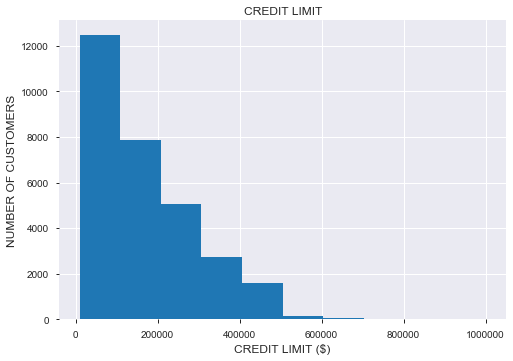

In [24]:
#histogram of customer credit limit with 10 bins
plt.hist(credit['LIMIT_BAL'], bins=10)
plt.xlabel('CREDIT LIMIT ($)', fontsize='large')
plt.ylabel('NUMBER OF CUSTOMERS', fontsize='large')
plt.title('CREDIT LIMIT', fontsize='large')
plt.show()

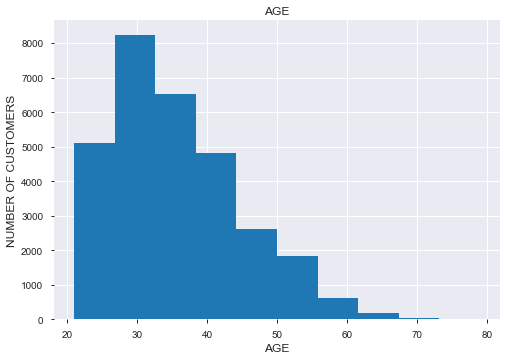

In [25]:
#histogram of age with 10 bins
plt.hist(credit['AGE'],bins = 10)
plt.xlabel('AGE', fontsize='large')
plt.ylabel('NUMBER OF CUSTOMERS', fontsize='large')
plt.title('AGE', fontsize='large')
plt.show()

Text(0.5, 1.0, 'Distribution of Customer Ages')

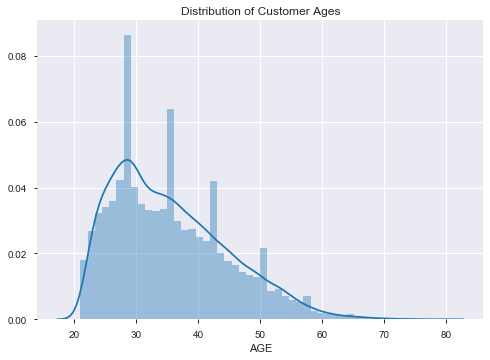

In [26]:
#Distribution plot of customer ages, with an overlay of a density plot
age = credit['AGE']
age_dist=sns.distplot(age)
age_dist.set_title("Distribution of Customer Ages")

## Line Plots

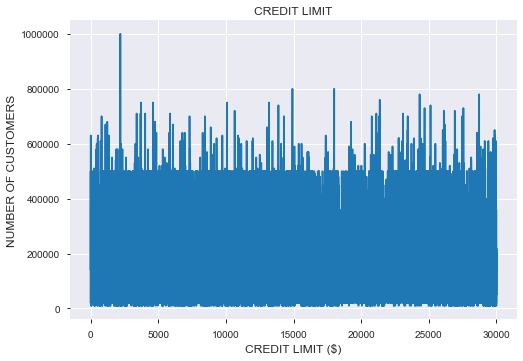

In [27]:
#line plot of credit limit
plt.plot(credit['LIMIT_BAL'])
plt.xlabel('CREDIT LIMIT ($)', fontsize='large')
plt.ylabel('NUMBER OF CUSTOMERS', fontsize='large')
plt.title('CREDIT LIMIT', fontsize='large')
plt.show()

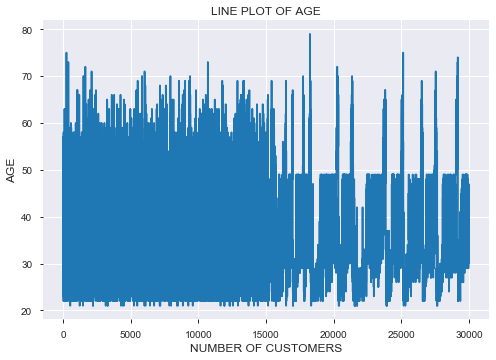

In [28]:
#line plot of age
plt.plot(credit['AGE'])
plt.xlabel('NUMBER OF CUSTOMERS', fontsize='large')
plt.ylabel('AGE', fontsize='large')
plt.title('LINE PLOT OF AGE', fontsize='large')
plt.show()

## Scatter Plots

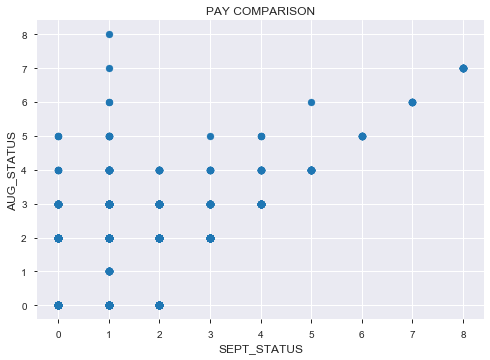

In [29]:
# Scatter plot comparing Sept status vs Aug status
x = credit['SEPT_STATUS']
y = credit['AUG_STATUS']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('AUG_STATUS', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

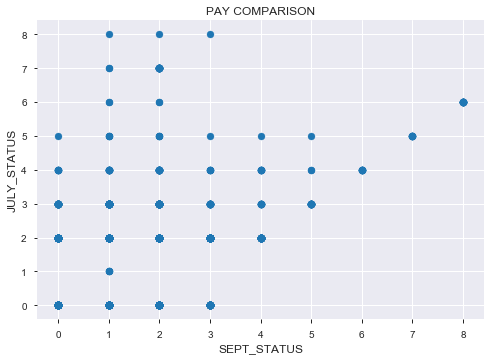

In [30]:
# Scatter plot comparing Sept status vs July status
x = credit['SEPT_STATUS']
y = credit['JULY_STATUS']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('JULY_STATUS', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

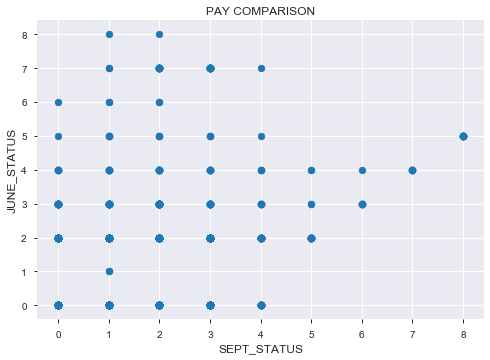

In [31]:
# Scatter plot comparing Sept status vs June status
x = credit['SEPT_STATUS']
y = credit['JUNE_STATUS']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('JUNE_STATUS', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

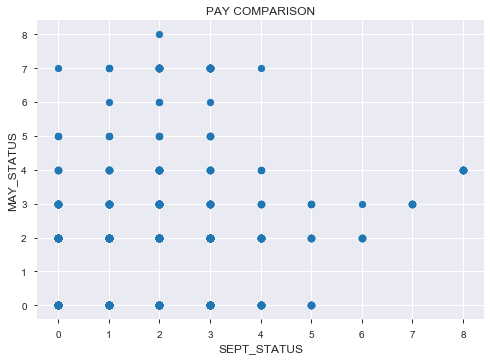

In [32]:
# Scatter plot comparing Sept status vs May status
x = credit['SEPT_STATUS']
y = credit['MAY_STATUS']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('MAY_STATUS', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

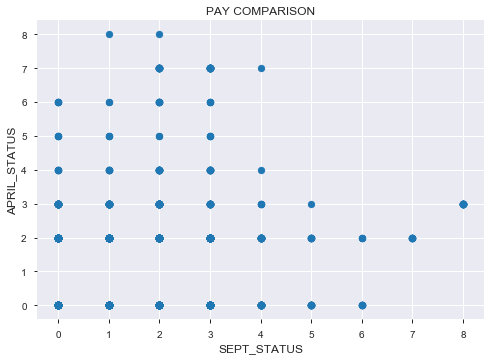

In [33]:
# Scatter plot comparing Sept status vs April status
x = credit['SEPT_STATUS']
y = credit['APRIL_STATUS']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('APRIL_STATUS', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

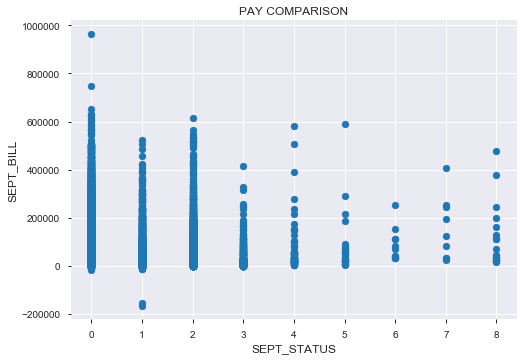

In [34]:
# Scatter plot comparing Sept Status vs September Bill
x = credit['SEPT_STATUS']
y = credit['SEPT_BILL']
plt.scatter(x,y)
plt.xlabel('SEPT_STATUS', fontsize='large')
plt.ylabel('SEPT_BILL', fontsize='large')
plt.title('PAY COMPARISON', fontsize='large')
plt.show()

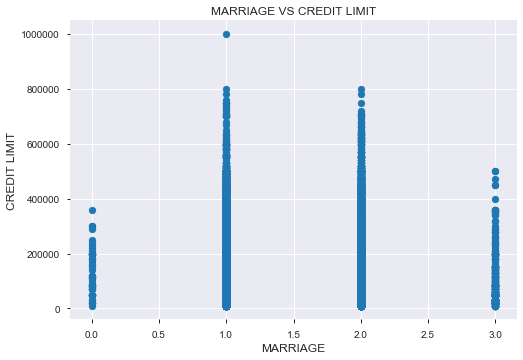

In [35]:
# Scatter plot of Marriage vs Credit Limit (0=OTHER, 1=MARRIED, 2=SINGLE, 3=DIVORCED)
x = credit['MARRIAGE']
y = credit['LIMIT_BAL']
plt.scatter(x,y)
plt.xlabel('MARRIAGE', fontsize='large')
plt.ylabel('CREDIT LIMIT', fontsize='large')
plt.title('MARRIAGE VS CREDIT LIMIT', fontsize='large')
plt.show()

## Seaborn Plots

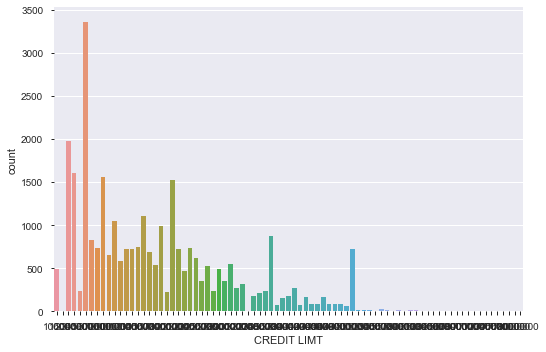

In [36]:
#Plot of CREDIT LIMIT
fg = sns.catplot('LIMIT_BAL', data=credit, kind='count', aspect=1.5)
fg.set_xlabels('CREDIT LIMT')

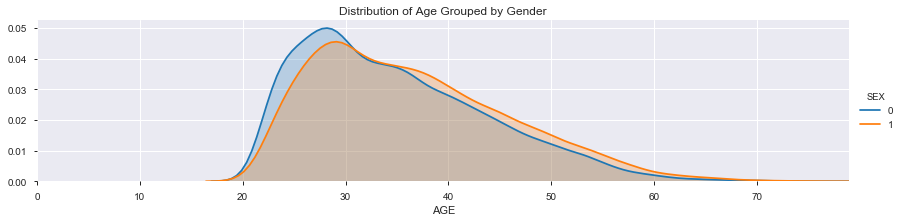

In [37]:
# distribution of age grouped by gender
fig = sns.FacetGrid(credit, hue='SEX', aspect=4)
fig.map(sns.kdeplot, 'AGE', shade=True)
oldest = credit['AGE'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Age Grouped by Gender')
fig.add_legend()

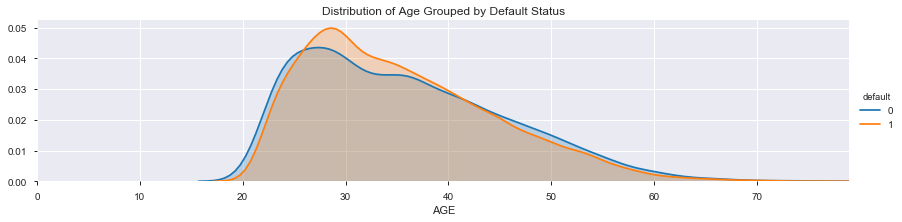

In [38]:
#Distribution of Age grouped by Default Status
fig = sns.FacetGrid(credit, hue='default', aspect=4)
fig.map(sns.kdeplot, 'AGE', shade=True)
oldest = credit['AGE'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Age Grouped by Default Status')
fig.add_legend()

In [39]:
#Column Headers
header =  credit.dtypes.index
print(header)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'SEPT_STATUS',
       'AUG_STATUS', 'JULY_STATUS', 'JUNE_STATUS', 'MAY_STATUS',
       'APRIL_STATUS', 'SEPT_BILL', 'AUG_BILL', 'JULY_BILL', 'JUNE_BILL',
       'MAY_BILL', 'APRIL_BILL', 'SEPT_PAYMENT', 'AUG_PAYMENT', 'JULY_PAYMENT',
       'JUNE_PAYMENT', 'MAY_PAYMENT', 'APRIL_PAYMENT', 'default',
       'LIMIT_BIN_CAT'],
      dtype='object')


## Box Plots Bills

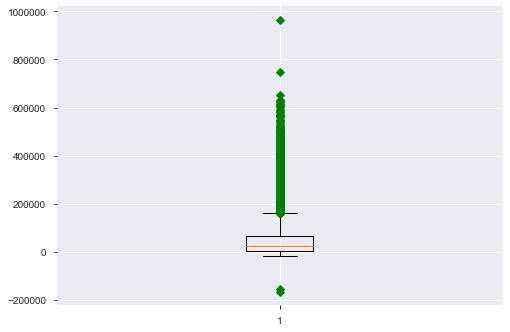

In [40]:
#box plot of Sept Bill
A = credit['SEPT_BILL']
plt.boxplot(A,0,'gD')
plt.show()

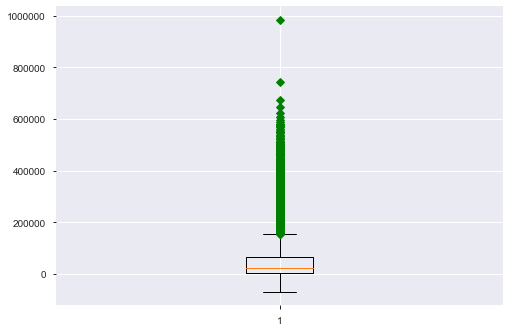

In [41]:
#box plot of Aug Bill
A = credit['AUG_BILL']
plt.boxplot(A,0,'gD')
plt.show()

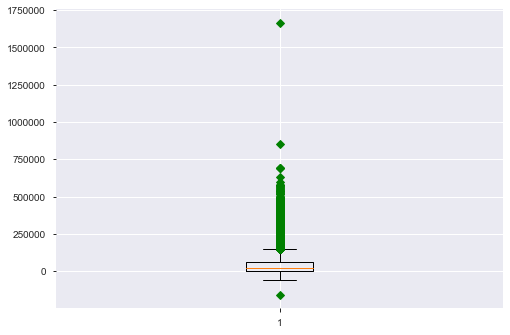

In [42]:
#box plot of July Bill
A = credit['JULY_BILL']
plt.boxplot(A,0,'gD')
plt.show()

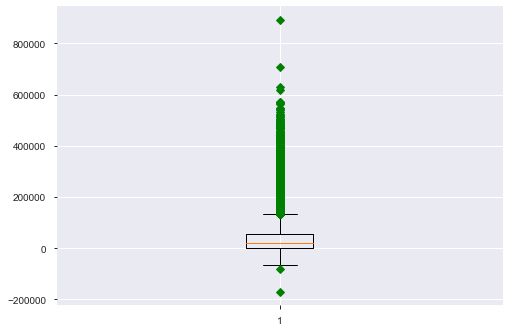

In [43]:
#box plot of June Bill
A = credit['JUNE_BILL']
plt.boxplot(A,0,'gD')
plt.show()

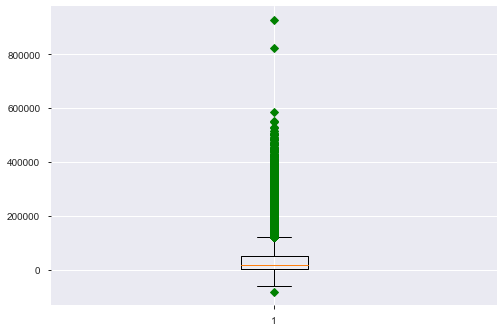

In [44]:
#box plot of May Bill
A = credit['MAY_BILL']
plt.boxplot(A,0,'gD')
plt.show()

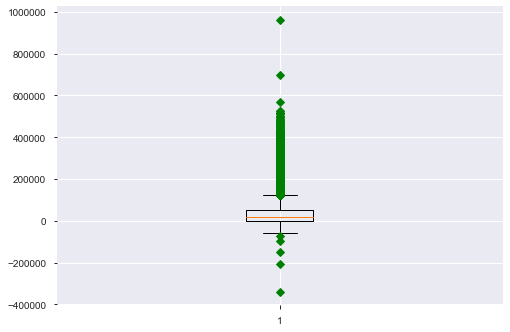

In [45]:
#box plot of April Bill
A = credit['APRIL_BILL']
plt.boxplot(A,0,'gD')
plt.show()

## Box Plots Payments

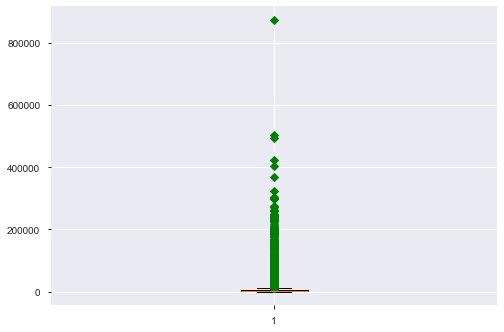

In [46]:
#box plot of Sept Payment
A = credit['SEPT_PAYMENT']
plt.boxplot(A,0,'gD')
plt.show()

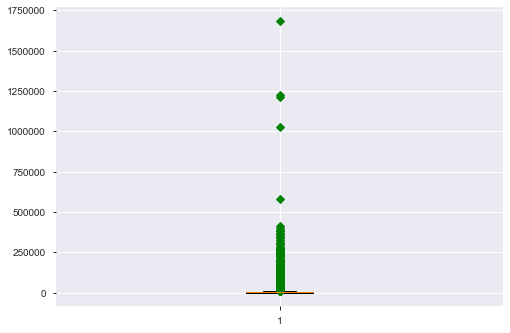

In [47]:
#box plot of Aug Payment
A = credit['AUG_PAYMENT']
plt.boxplot(A,0,'gD')
plt.show()

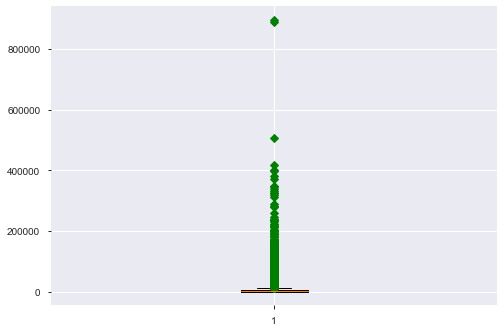

In [48]:
#box plot of July Payment
A = credit['JULY_PAYMENT']
plt.boxplot(A,0,'gD')
plt.show()

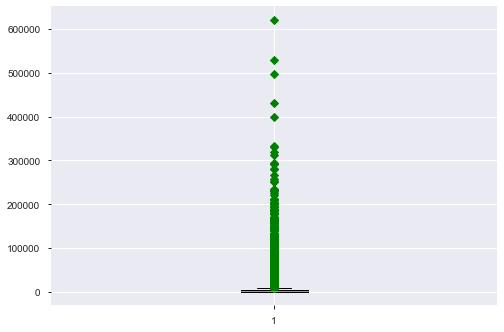

In [49]:
#box plot of June Payment
A = credit['JUNE_PAYMENT']
plt.boxplot(A,0,'gD')
plt.show()

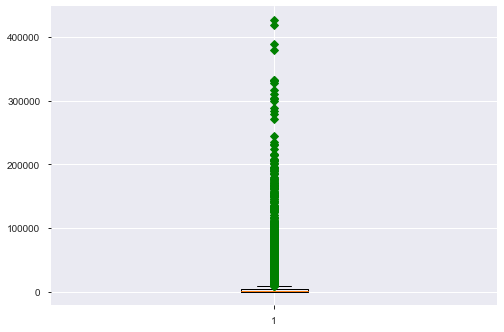

In [50]:
#box plot of May Payment
A = credit['MAY_PAYMENT']
plt.boxplot(A,0,'gD')
plt.show()

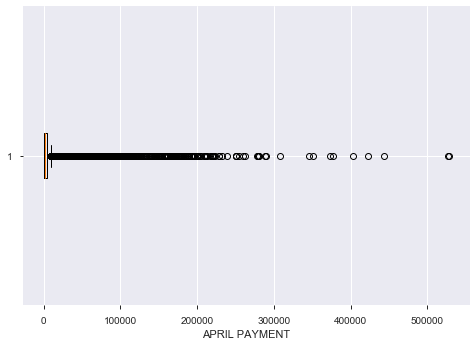

In [51]:
#box plot of April Payment displaying a horizontal portrayal option
plt.boxplot(credit.APRIL_PAYMENT, vert=False)
plt.xlabel('APRIL PAYMENT')
plt.show()

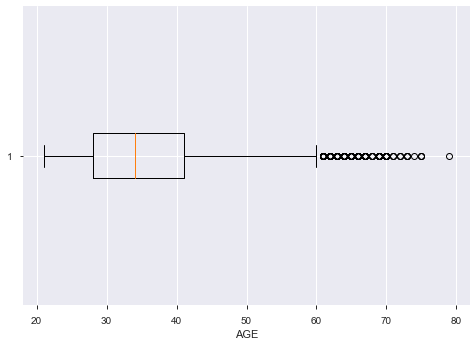

In [52]:
#Box Plot of Age
plt.boxplot(credit.AGE, vert=False)
plt.xlabel('AGE')
plt.show()

In [53]:
#Converts non-numeric column (Education) to 'dummy variables' so they can be used for regression.  Binary 0 or 1
credit = pd.get_dummies(credit)

In [54]:
#Confirm new dummy variable columns for Education, Sex, Default
credit.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,SEPT_STATUS,AUG_STATUS,JULY_STATUS,JUNE_STATUS,MAY_STATUS,APRIL_STATUS,...,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT,default,LIMIT_BIN_CAT,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university
0,20000,0,1,24,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,120000,0,2,26,0,2,0,0,0,2,...,1000,1000,0,2000,0,0,0,0,0,1
2,90000,0,2,34,0,0,0,0,0,0,...,1000,1000,1000,5000,1,0,0,0,0,1
3,50000,0,1,37,0,0,0,0,0,0,...,1200,1100,1069,1000,1,0,0,0,0,1
4,50000,1,1,57,0,0,0,0,0,0,...,10000,9000,689,679,1,0,0,0,0,1


In [55]:
#Ensure all data types are now numeric
credit.dtypes

LIMIT_BAL                    int64
SEX                          int32
MARRIAGE                     int64
AGE                          int64
SEPT_STATUS                  int64
AUG_STATUS                   int64
JULY_STATUS                  int64
JUNE_STATUS                  int64
MAY_STATUS                   int64
APRIL_STATUS                 int64
SEPT_BILL                    int64
AUG_BILL                     int64
JULY_BILL                    int64
JUNE_BILL                    int64
MAY_BILL                     int64
APRIL_BILL                   int64
SEPT_PAYMENT                 int64
AUG_PAYMENT                  int64
JULY_PAYMENT                 int64
JUNE_PAYMENT                 int64
MAY_PAYMENT                  int64
APRIL_PAYMENT                int64
default                      int32
LIMIT_BIN_CAT                int32
EDUCATION_graduate school    uint8
EDUCATION_high school        uint8
EDUCATION_other              uint8
EDUCATION_university         uint8
dtype: object

## Correlation

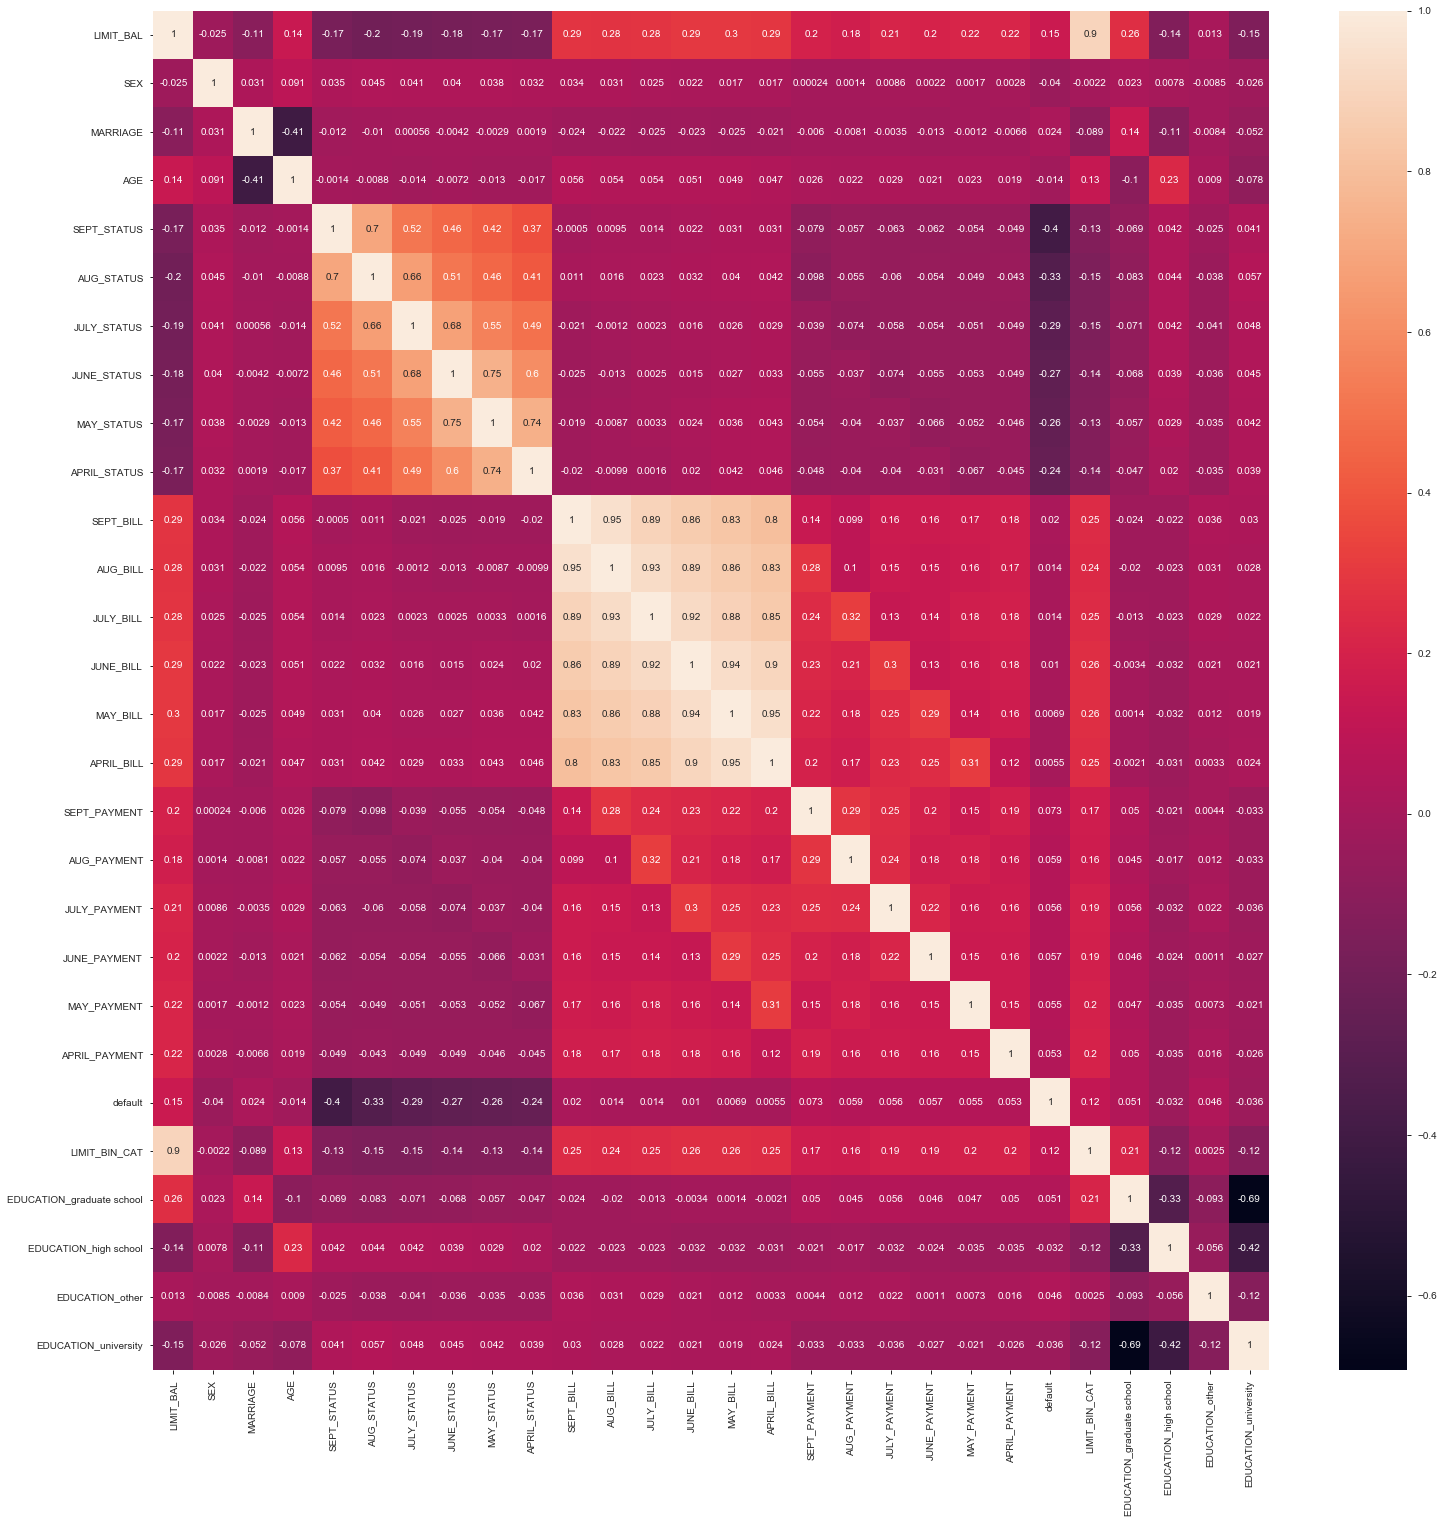

In [56]:
#correlation
credit_corr = credit.corr()
plt.figure(figsize=(25,25))
sns.heatmap(credit_corr, annot=True)
plt.show()

## Correlation Findings

In [57]:
#Findings: Pay Status, Sex, Marriage, and Education (university, high school, other) have low correlation and can be removed

In [58]:
#Drop additional unneeded columns
credit = credit.drop(['SEPT_STATUS', 'AUG_STATUS', 'JULY_STATUS', 'JUNE_STATUS', 'MAY_STATUS', 'APRIL_STATUS', 'MARRIAGE', 'SEX', 'EDUCATION_high school', 'EDUCATION_other', 'EDUCATION_university'], axis=1)

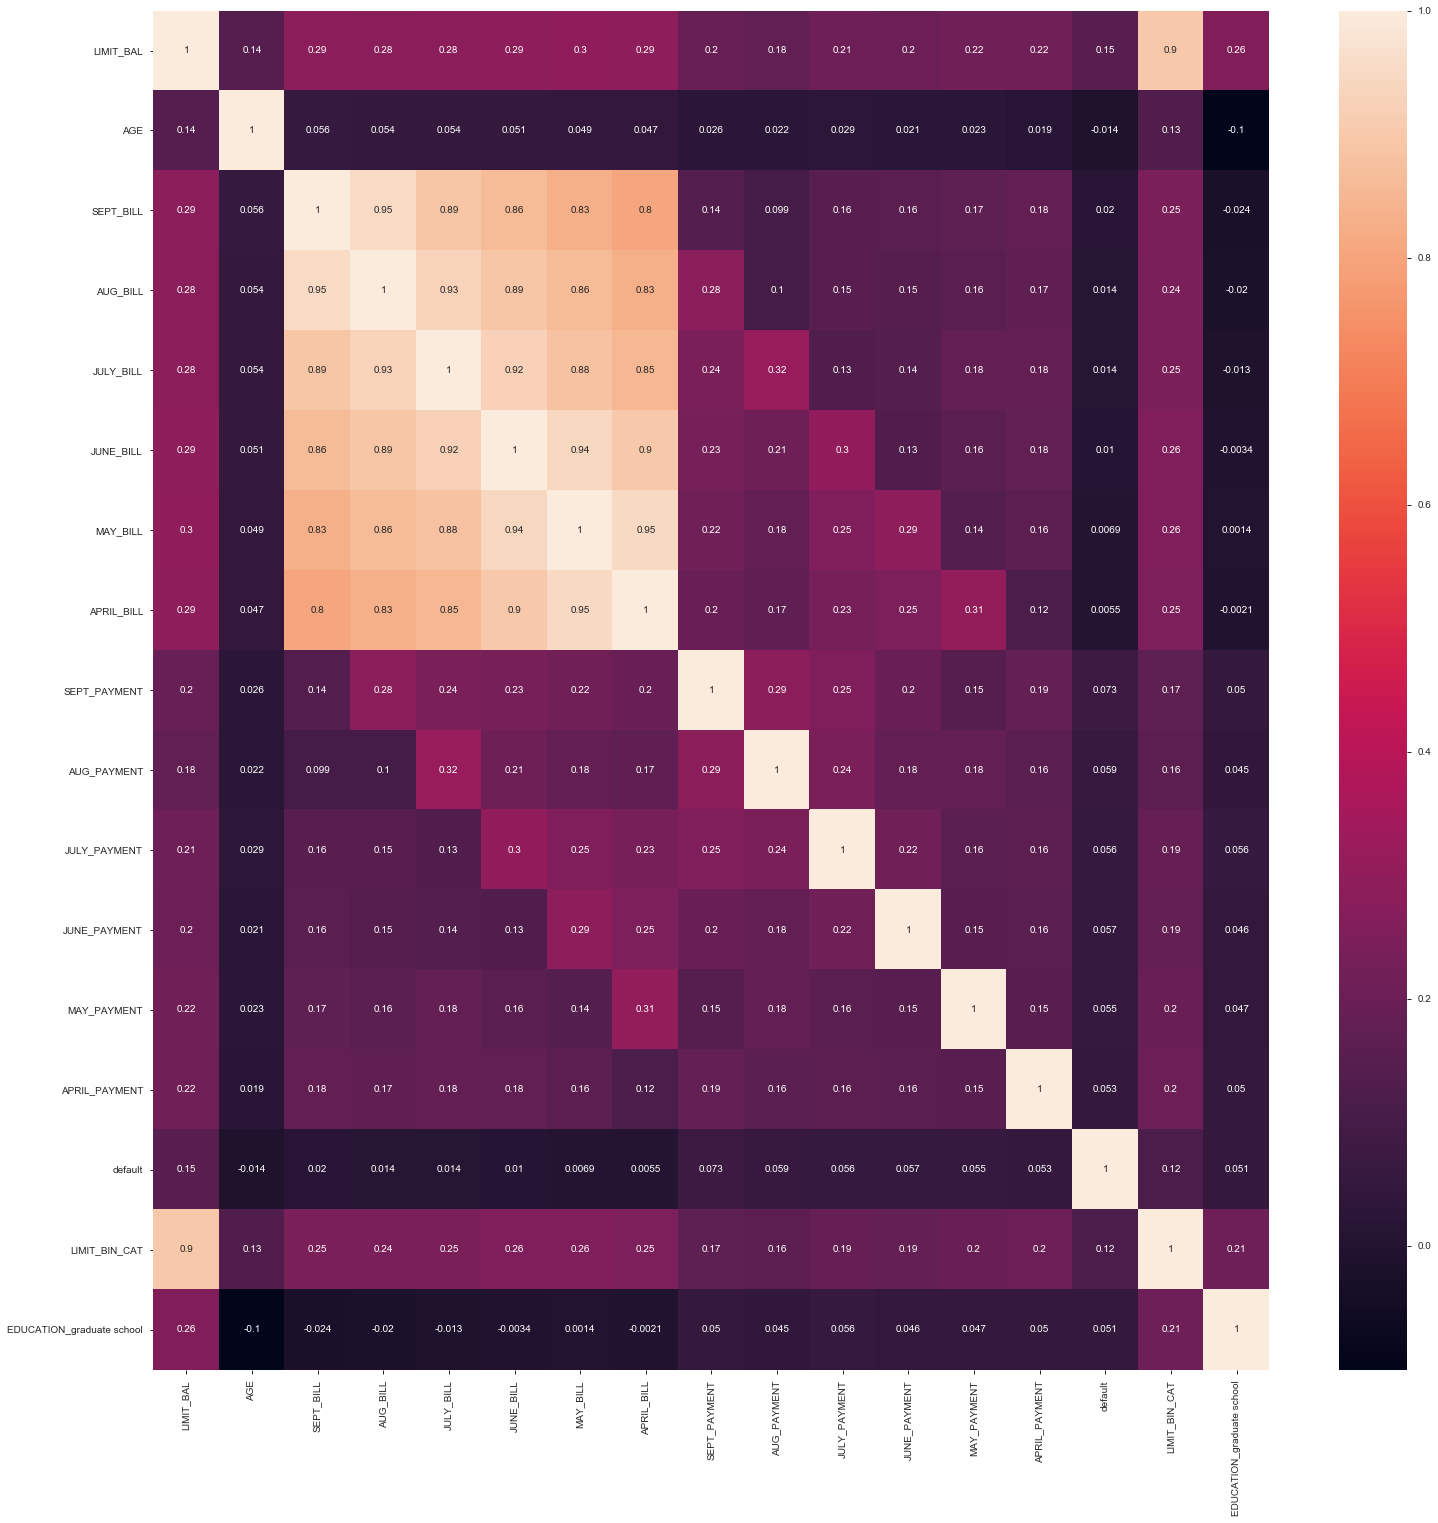

In [59]:
#repeat correlation matrix
credit_corr = credit.corr()
plt.figure(figsize=(25,25))
sns.heatmap(credit_corr, annot=True)
plt.show()

## Choose and Evaluate Models

In [60]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29965 entries, 0 to 29999
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   LIMIT_BAL                  29965 non-null  int64
 1   AGE                        29965 non-null  int64
 2   SEPT_BILL                  29965 non-null  int64
 3   AUG_BILL                   29965 non-null  int64
 4   JULY_BILL                  29965 non-null  int64
 5   JUNE_BILL                  29965 non-null  int64
 6   MAY_BILL                   29965 non-null  int64
 7   APRIL_BILL                 29965 non-null  int64
 8   SEPT_PAYMENT               29965 non-null  int64
 9   AUG_PAYMENT                29965 non-null  int64
 10  JULY_PAYMENT               29965 non-null  int64
 11  JUNE_PAYMENT               29965 non-null  int64
 12  MAY_PAYMENT                29965 non-null  int64
 13  APRIL_PAYMENT              29965 non-null  int64
 14  default               

In [61]:
credit.head()

,LIMIT_BAL,AGE,SEPT_BILL,AUG_BILL,JULY_BILL,JUNE_BILL,MAY_BILL,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT,default,LIMIT_BIN_CAT,EDUCATION_graduate school
0,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,1,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,1,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,1,0,0


In [62]:
#Features (i stands for integer in iloc, iloc is exclusive of the 2nd number in range, iloc selects columns based on integer
#position, when using loc you use the column heading names and it is inclusive of both columns in range)
X = credit.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,16]]
print('Summary of feature sample')
X.head()

Summary of feature sample


,AGE,SEPT_BILL,AUG_BILL,JULY_BILL,JUNE_BILL,MAY_BILL,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT,default,EDUCATION_graduate school
0,24,3913,3102,689,0,0,0,0,689,0,0,0,0,0,0
1,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0,0
2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,1,0
3,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,1,0
4,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,1,0


In [63]:
#dependent variable is LIMIT_BAL_CAT
y = credit.loc[:,'LIMIT_BIN_CAT']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: LIMIT_BIN_CAT, dtype: int32

In [64]:
#Define the 3 selected models
algos_Class = []
algos_Class.append(('Random Forest Classifier', RandomForestClassifier()))
algos_Class.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))
algos_Class.append(('Support Vector Classifier', SVC()))

In [65]:
#classification modeling
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=3, scoring = 'accuracy')
    names.append(name)
    results.append(result)

C:\Users\Owner\Anaconda3\envs\blackwell\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Owner\Anaconda3\envs\blackwell\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Owner\Anaconda3\envs\blackwell\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


In [66]:
# Get results of the 3 selected models
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier 0.7356916630453424
Gradient Boosting Classifier 0.741665237715298
Support Vector Classifier 0.7232437927080889


In [67]:
#Train/Test Split 70% training, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

## Random Forest Classifier

In [68]:
#Modeling (Random Forest Classifier), default = 100 trees
algo = RandomForestClassifier()
model = algo.fit(X_train,y_train)
print (model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [69]:
#Make Predictions
predictions = model.predict(X_test)
accuracy_score = accuracy_score(y_test,predictions)
print('accuracy score: %.3f' % accuracy_score)

accuracy score: 0.739


## Confusion Matrix

In [70]:
# Visualise classical Confusion Matrix
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      6121
           1       0.56      0.42      0.48      2318
           2       0.57      0.11      0.19       527
           3       0.00      0.00      0.00        24

    accuracy                           0.74      8990
   macro avg       0.48      0.36      0.38      8990
weighted avg       0.71      0.74      0.71      8990



[[5599  516    6    0]
 [1305  984   29    0]
 [ 218  249   60    0]
 [   9    5   10    0]]


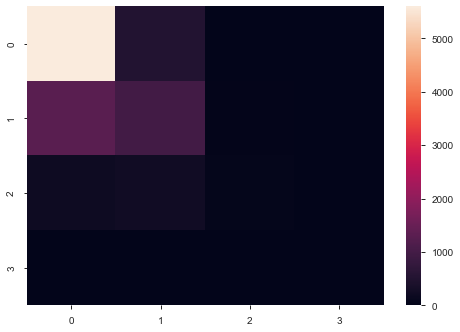

In [71]:
# Visualise classical Confusion Matrix
y_pred = model.predict(X_test)
CM = confusion_matrix(y_test, y_pred)
print(CM)

# Visualize it as a heatmap
sns.heatmap(CM)
plt.show()

## Feature Importance

In [72]:
#feature importance determination (age, sept bill, and aug bill have the highest importance)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print (importances)

[0.09052753 0.10672305 0.09489598 0.07799834 0.06579057 0.06324571
 0.06441419 0.07033434 0.07194867 0.06802872 0.0568     0.06525488
 0.07090879 0.01082856 0.02230068]
